In the following analysis we used the public dataset:

Llorens-Bobadilla, Enric, et al. "Single-cell transcriptomics reveals a population of dormant neural stem cells that become activated upon brain injury." Cell Stem Cell 17.3 (2015): 329-340.
http://dx.doi.org/10.1016/j.stem.2015.07.002

Processed data was downloaded from GEO website: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE67833

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from scipy.stats.stats import pearsonr 

%matplotlib inline
cmap=cm.get_cmap('RdBu_r')
sns.set_style('white')
sns.set_context('notebook', font_scale=1.7, rc={'lines.linewidth': 1.3})

# calculates the correlation between two genes
def pcorr(x,y, log_scale=False):
    if log_scale:
        x = np.log2(x)
        y = np.log2(y)
    [corr,p] = pearsonr(x, y)
    a,b   = np.polyfit(x, y, 1) 
    return [a, b, corr, p]

# calculate the expression of a list of genes defined in D['list_genes] in the log2(X+1) scale
def get_expression(D):
    out = []
    for i in range(len(D['list_genes'])):
        out += [np.sum(D['data'].loc[D['list_genes'][i]].values, axis=0)]
    return np.log2(np.array(out)+1)

# convert ensembl ID to gene name
Xi = pd.read_csv('./Ensembl_IDs.txt', index_col=None, header=0)
def ensembl_to_geneID(Xi, g):
    return [[Xi[Xi['WikiGene Name']==i]['Ensembl Gene ID'].values[0] for i in g[j]] for j in range(len(g))]

In [2]:
# Reading downloaded processed data from GEO site
X1 = pd.read_csv('./GSE67833_Gene_expression_matrix.csv',                index_col=0, header=0)
X2 = pd.read_csv('./GSE67833_Gene_expression_matrix_GSM1684656-704.csv', index_col=0, header=0)


D = {}
D['data'] = pd.concat([X1, X2], axis=1, join='inner')

cl = pd.DataFrame(index=['cl'], columns=D['data'].columns)
for i in cl.columns: 
    if i[0] == 'N':    # control NSCs
        cl[i] = 0.0
    elif i[0] == 't':  # TAP cells
        cl[i] = 1.0

D['data']   = D['data'][cl.columns[cl.loc['cl']<=1]]
cl   = cl[cl.columns[cl.loc['cl']<=1]]
D['marker'] = np.array([str(i).replace('0.0','o').replace('1.0','>') for i in cl.values[0]])

print 'Number of NSC  =', np.sum(cl.values==0.0)
print 'Number of tap  =', np.sum(cl.values==1.0)
D['data'].head()

Number of NSC  = 130
Number of tap  = 27


,N1,N11,N13,N17,N18,N2,N22,N23,N24,N25,...,tap62,tap61,tap60,tap59,tap58,tap56,tap55,tap54,tap50,tap49
ENSMUSG00000099985,0.000,0.000,0.038,0.00,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
ENSMUSG00000030105,16.498,0.000,0.089,0.00,63.615,0.068,312.755,88.253,76.513,0.000,...,58.356,64.274,115.027,0.000,94.013,137.899,74.606,91.661,101.311,139.724
ENSMUSG00000098001,0.509,0.252,0.051,0.43,0.264,0.361,0.168,0.122,0.190,0.327,...,0.940,0.486,1.629,0.135,0.498,0.893,0.305,0.000,0.591,0.327
ENSMUSG00000096054,0.000,0.511,0.000,0.00,0.000,0.090,0.042,3.288,0.000,57.626,...,0.097,0.045,0.092,0.000,0.000,0.045,0.000,0.000,0.357,0.187
ENSMUSG00000074445,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [3]:
l = {}  # relevant list of genes
l['Hes']  = ['Hes1', 'Hes5']
l['NSC']  = ['Slc1a3', 'Nr2e1', 'Sox9','Vcam1']
l['NSC2'] = ['Nes', 'Slc1a3', 'Sox2','Vim', 'Itgb1'] # alternative list of NSC markers
l['aNSC'] = ['Ascl1', 'Fos', 'Egr1', 'Sox4', 'Sox11']
l['IDs' ] = ['Id1', 'Id2', 'Id3', 'Id4']
l['Dll']  = ['Dll1', 'Dll3', 'Dll4']

/usr/local/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


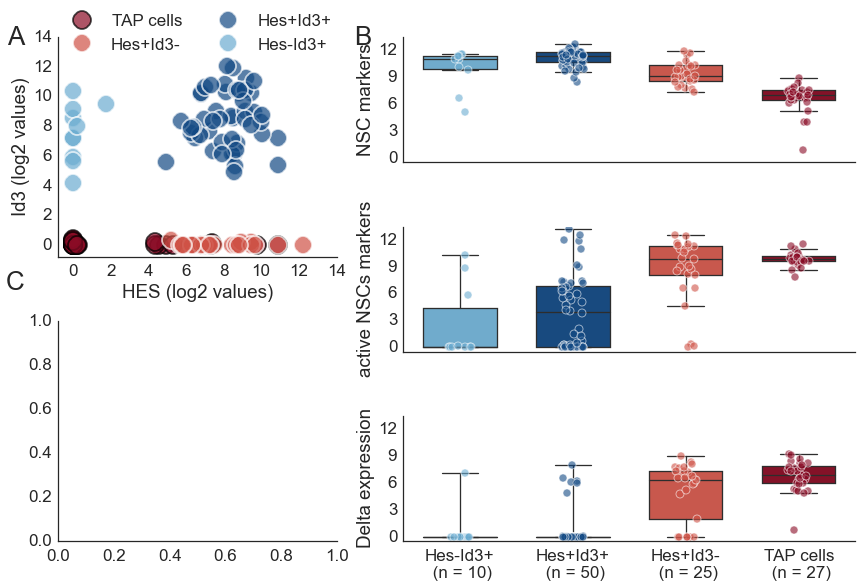

In [4]:
# ------------------------- Figure 3A,B -------------------------------------------------
f = plt.subplots(6, 5, figsize=(12, 8))
plt.subplots_adjust(wspace=0.8)
ax = plt.subplot2grid((6, 5), (0, 0), colspan=2, rowspan=3)
ax.text(-3.5, 13.5, 'A', fontsize=26)
ax.text(15.0, 13.5, 'B', fontsize=26)
ax.text(-3.5, -3.0, 'C', fontsize=26)

D['list_genes'] = ensembl_to_geneID(Xi,[l['Hes'], ['Id3'], l['NSC'], l['aNSC'], l['Dll']])
x = get_expression(D)

tr = 2    # threshould for seggregating NSCs into subpopulations
t = [(x[0] < tr) & (x[1] > tr) & (D['marker']=='o'),   #  Hes-Id3+ NSCs
     (x[0] > tr) & (x[1] > tr) & (D['marker']=='o'),   #  Hes+Id3+ NSCs
     (x[0] > tr) & (x[1] < tr) & (D['marker']=='o'),   #  Hes+Id3- NSCs
     (D['marker']!='o')]                               #  TAP cells
m     = ['o','o','o','o']
mec   = ['w','w','w','k']
c     = [cmap(0.25), cmap(0.05), cmap(0.82), cmap(0.95), 'y']
label = ['Hes-Id3+','Hes+Id3+','Hes+Id3-', 'TAP cells']

for i in np.arange(len(t)-1, -1, -1):
    plt.plot(x[0][t[i]], x[1][t[i]], marker=m[i], color=c[i], lw=0.0, mew=1.8, 
             mec=mec[i], ms=18, alpha=0.7, label=label[i])  
ax.set_xlabel('HES (log2 values)')
ax.set_ylabel('Id3 (log2 values)')
ax.set_xlim([-0.8,14])
ax.set_ylim([-0.8,14])
plt.legend(bbox_to_anchor=(0., 0.9, 1., .1), loc=3, ncol=2, mode="expand", borderaxespad=0.)


ax = plt.subplot2grid((6, 5), (3, 0), colspan=2, rowspan=3)
ylim = [[-0.5,13.5], [-0.5,13.5], [-0.5,13.5]]
ylabel = ['NSC markers', 'active NSCs markers', 'Delta expression']
for i in range(3):
    ax = plt.subplot2grid((6, 5), (2*i, 2), colspan=3, rowspan=2)
    sns.boxplot(  data=[x[2+i][t[j]] for j in range(4)], palette=c, ax=ax,
                  saturation=0.9, width=0.65, fliersize=0)
    sns.stripplot(data=[x[2+i][t[j]] for j in range(4)], jitter=True, palette=c, size=8,
                  linewidth=0.9, edgecolor='w', marker='o', ax=ax, alpha=0.6)
    ax.set_xticks([0, 1, 2, 3])
    if i==2:
        ax.set_xticklabels([label[j]+'\n (n = '+str(np.sum(t[j]))+')' for j in range(4)])
    else:
        ax.set_xticklabels([])        
    ax.set_yticks([0, 3, 6, 9, 12])
    ax.set_ylabel(ylabel[i])
    ax.set_ylim(ylim[i])
sns.despine()
plt.tight_layout()
#plt.savefig('./Figure3_AdultBrain.pdf', format='pdf', dpi=200)

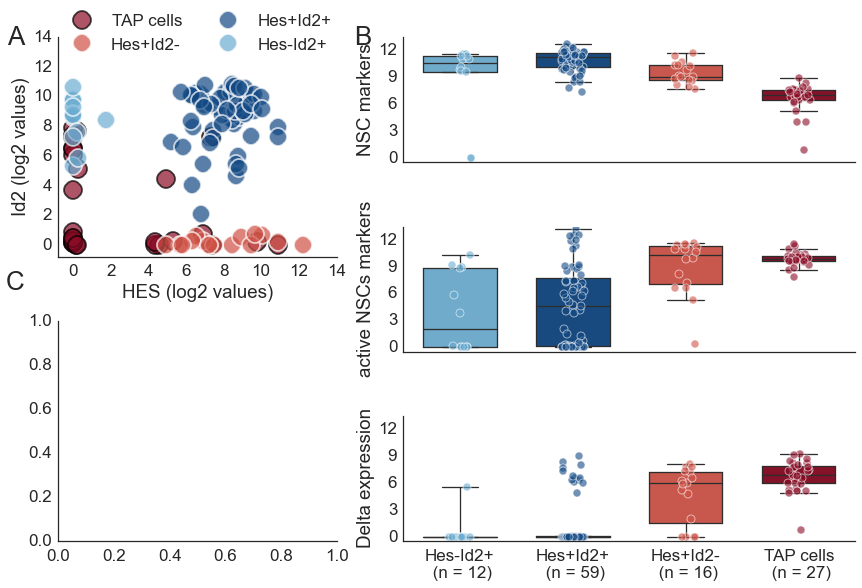

In [5]:
# ------------------------- Figure S3 ------------------------------------------------
f = plt.subplots(6, 5, figsize=(12, 8))
plt.subplots_adjust(wspace=0.8)
ax = plt.subplot2grid((6, 5), (0, 0), colspan=2, rowspan=3)
ax.text(-3.5, 13.5, 'A', fontsize=26)
ax.text(15.0, 13.5, 'B', fontsize=26)
ax.text(-3.5, -3.0, 'C', fontsize=26)

D['list_genes'] = ensembl_to_geneID(Xi,[l['Hes'], ['Id2'], l['NSC'], l['aNSC'], l['Dll']])
x = get_expression(D)

tr = 2    # threshould for seggregating NSCs into subpopulations
t = [(x[0] < tr) & (x[1] > tr) & (D['marker']=='o'),   #  Hes-Id2+ NSCs
     (x[0] > tr) & (x[1] > tr) & (D['marker']=='o'),   #  Hes+Id2+ NSCs
     (x[0] > tr) & (x[1] < tr) & (D['marker']=='o'),   #  Hes+Id2- NSCs
     (D['marker']!='o')]                               #  TAP cells
m     = ['o','o','o','o']
mec   = ['w','w','w','k']
c     = [cmap(0.25), cmap(0.05), cmap(0.82), cmap(0.95), 'y']
label = ['Hes-Id2+','Hes+Id2+','Hes+Id2-', 'TAP cells']

for i in np.arange(len(t)-1, -1, -1):
    plt.plot(x[0][t[i]], x[1][t[i]], marker=m[i], color=c[i], lw=0.0, mew=1.8, 
             mec=mec[i], ms=18, alpha=0.7, label=label[i])  
ax.set_xlabel('HES (log2 values)')
ax.set_ylabel('Id2 (log2 values)')
ax.set_xlim([-0.8,14])
ax.set_ylim([-0.8,14])
plt.legend(bbox_to_anchor=(0., 0.9, 1., .1), loc=3, ncol=2, mode="expand", borderaxespad=0.)


ax = plt.subplot2grid((6, 5), (3, 0), colspan=2, rowspan=3)
ylim = [[-0.5,13.5], [-0.5,13.5], [-0.5,13.5]]
ylabel = ['NSC markers', 'active NSCs markers', 'Delta expression']
for i in range(3):
    ax = plt.subplot2grid((6, 5), (2*i, 2), colspan=3, rowspan=2)
    sns.boxplot(  data=[x[2+i][t[j]] for j in range(4)], palette=c, ax=ax,
                  saturation=0.9, width=0.65, fliersize=0)
    sns.stripplot(data=[x[2+i][t[j]] for j in range(4)], jitter=True, palette=c, size=8,
                  linewidth=0.9, edgecolor='w', marker='o', ax=ax, alpha=0.6)
    ax.set_xticks([0, 1, 2, 3])
    if i==2:
        ax.set_xticklabels([label[j]+'\n (n = '+str(np.sum(t[j]))+')' for j in range(4)])
    else:
        ax.set_xticklabels([])        
    ax.set_yticks([0, 3, 6, 9, 12])
    ax.set_ylabel(ylabel[i])
    ax.set_ylim(ylim[i])
sns.despine()
plt.tight_layout()
#plt.savefig('./FigureS3_AdultBrain_Id2.pdf', format='pdf', dpi=200)

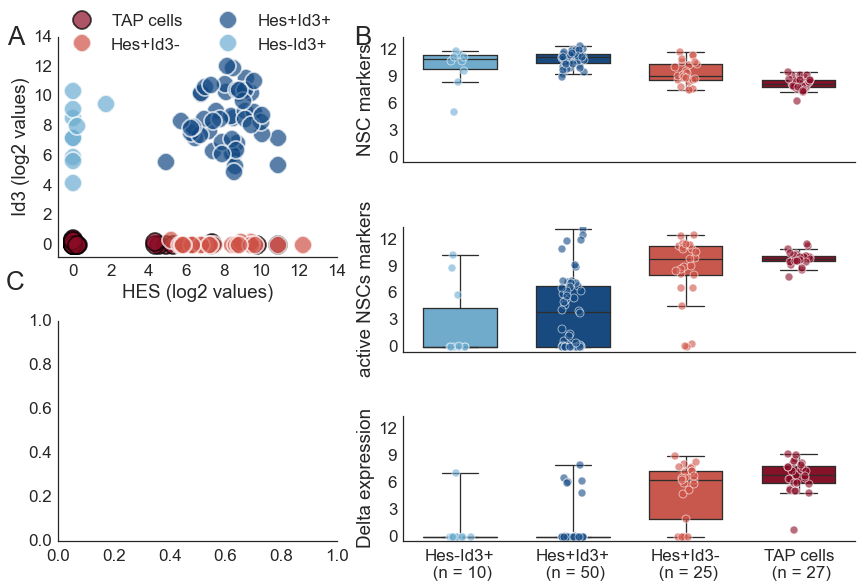

In [6]:
# ------------------------- Figure S4 -----------------------------------------------
f = plt.subplots(6, 5, figsize=(12, 8))
plt.subplots_adjust(wspace=0.8)
ax = plt.subplot2grid((6, 5), (0, 0), colspan=2, rowspan=3)
ax.text(-3.5, 13.5, 'A', fontsize=26)
ax.text(15.0, 13.5, 'B', fontsize=26)
ax.text(-3.5, -3.0, 'C', fontsize=26)

D['list_genes'] = ensembl_to_geneID(Xi,[l['Hes'], ['Id3'], l['NSC2'], l['aNSC'], l['Dll']])
x = get_expression(D)

tr = 2    # threshould for seggregating NSCs into subpopulations
t = [(x[0] < tr) & (x[1] > tr) & (D['marker']=='o'),   #  Hes-Id3+ NSCs
     (x[0] > tr) & (x[1] > tr) & (D['marker']=='o'),   #  Hes+Id3+ NSCs
     (x[0] > tr) & (x[1] < tr) & (D['marker']=='o'),   #  Hes+Id3- NSCs
     (D['marker']!='o')]                               #  TAP cells
m     = ['o','o','o','o']
mec   = ['w','w','w','k']
c     = [cmap(0.25), cmap(0.05), cmap(0.82), cmap(0.95), 'y']
label = ['Hes-Id3+','Hes+Id3+','Hes+Id3-', 'TAP cells']

for i in np.arange(len(t)-1, -1, -1):
    plt.plot(x[0][t[i]], x[1][t[i]], marker=m[i], color=c[i], lw=0.0, mew=1.8, 
             mec=mec[i], ms=18, alpha=0.7, label=label[i])  
ax.set_xlabel('HES (log2 values)')
ax.set_ylabel('Id3 (log2 values)')
ax.set_xlim([-0.8,14])
ax.set_ylim([-0.8,14])
plt.legend(bbox_to_anchor=(0., 0.9, 1., .1), loc=3, ncol=2, mode="expand", borderaxespad=0.)


ax = plt.subplot2grid((6, 5), (3, 0), colspan=2, rowspan=3)
ylim = [[-0.5,13.5], [-0.5,13.5], [-0.5,13.5]]
ylabel = ['NSC markers', 'active NSCs markers', 'Delta expression']
for i in range(3):
    ax = plt.subplot2grid((6, 5), (2*i, 2), colspan=3, rowspan=2)
    sns.boxplot(  data=[x[2+i][t[j]] for j in range(4)], palette=c, ax=ax,
                  saturation=0.9, width=0.65, fliersize=0)
    sns.stripplot(data=[x[2+i][t[j]] for j in range(4)], jitter=True, palette=c, size=8,
                  linewidth=0.9, edgecolor='w', marker='o', ax=ax, alpha=0.6)
    ax.set_xticks([0, 1, 2, 3])
    if i==2:
        ax.set_xticklabels([label[j]+'\n (n = '+str(np.sum(t[j]))+')' for j in range(4)])
    else:
        ax.set_xticklabels([])        
    ax.set_yticks([0, 3, 6, 9, 12])
    ax.set_ylabel(ylabel[i])
    ax.set_ylim(ylim[i])
sns.despine()
plt.tight_layout()

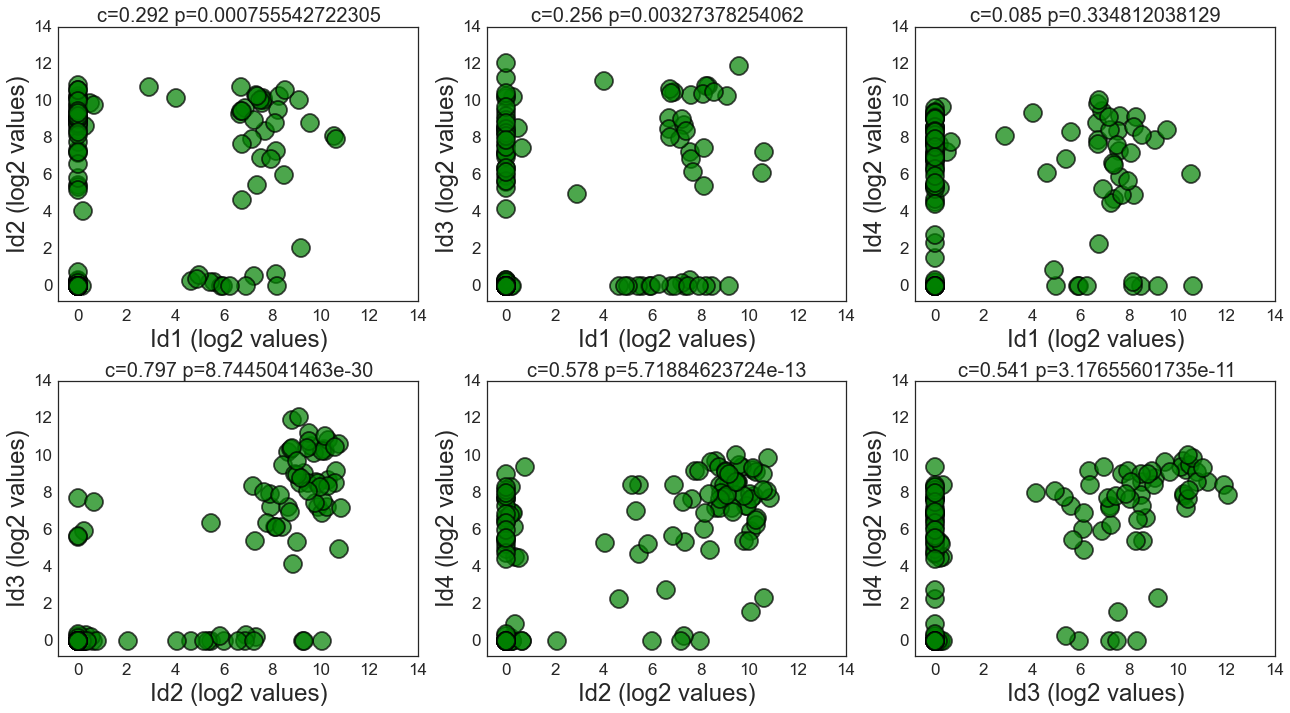

-----------------------------------------------------------------------------------



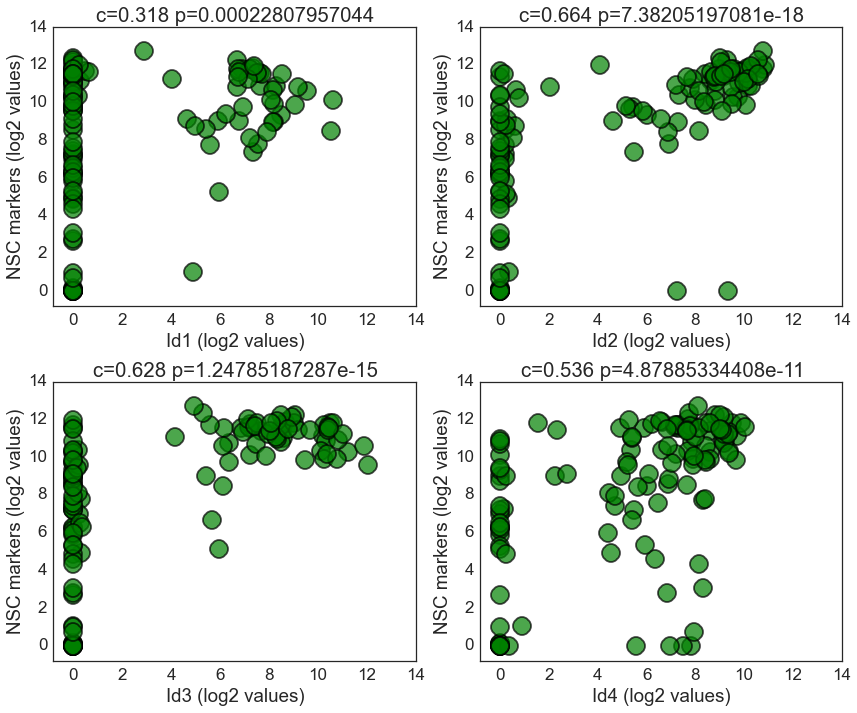

-----------------------------------------------------------------------------------



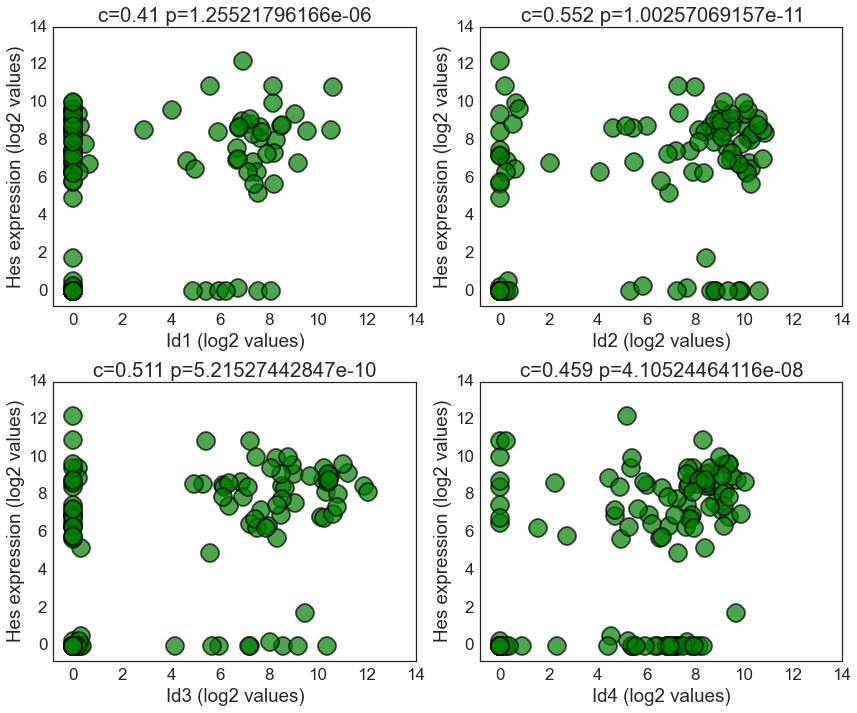

In [7]:
# ----------------------- IDs x IDs (Figure S1) -------------------------    
f = plt.subplots(3, 2, figsize=(6*3, 5*2), sharex=False)
for i in range(len(l['IDs'])):
    for j in range(len(l['IDs'])):
        if i<j:
            if i==0: 
                ax = plt.subplot2grid((2, 3), (i, j-1), colspan=1, rowspan=1)
            if i==1: 
                ax = plt.subplot2grid((2, 3), (i, j-2), colspan=1, rowspan=1)
            if i==2: 
                ax = plt.subplot2grid((2, 3), (1, 2), colspan=1, rowspan=1)
            D['list_genes'] = ensembl_to_geneID(Xi,[[l['IDs'][i]], [l['IDs'][j]]])
            x = get_expression(D)
            plt.plot(x[0][D['marker']=='o'], x[1][D['marker']=='o'], marker='o', color='g', 
                     lw=0.0, mew=1.8, ms=18, alpha=0.7)
            [a, b, corr, p] = pcorr(x[0][D['marker']=='o'], x[1][D['marker']=='o'])
            ax.set_title('c='+str(round(corr,3))+' p='+str(round(p,40)), fontsize=20)
            ax.set_xlabel(l['IDs'][i]+' (log2 values)', fontsize=24)
            ax.set_ylabel(l['IDs'][j]+' (log2 values)', fontsize=24)
            ax.set_xlim([-0.8,14])
            ax.set_ylim([-0.8,14])
plt.tight_layout()
plt.show()
print '-----------------------------------------------------------------------------------\n'

# ----------------------- IDs x NSC markers (Figure S2)-------------------------
f = plt.subplots(2, 2, figsize=(6*2, 5*2), sharex=False)
for i in range(len(l['IDs'])):
    ax = plt.subplot2grid((2, 2), (1*(i>1), i%2), colspan=1, rowspan=1)
    D['list_genes'] = ensembl_to_geneID(Xi,[[l['IDs'][i]], l['NSC']])
    x = get_expression(D)
    plt.plot(x[0][D['marker']=='o'], x[1][D['marker']=='o'], marker='o', color='g', 
             lw=0.0, mew=1.8, ms=18, alpha=0.7)
    [a, b, corr, p] = pcorr(x[0][D['marker']=='o'], x[1][D['marker']=='o'])
    ax.set_title('c='+str(round(corr,3))+' p='+str(round(p,40)))
    ax.set_ylabel('NSC markers (log2 values)')
    ax.set_xlabel(l['IDs'][i]+' (log2 values)')
    ax.set_xlim([-0.8,14])
    ax.set_ylim([-0.8,14])
plt.tight_layout()
plt.show()
print '-----------------------------------------------------------------------------------\n'

# ----------------------- IDs x Hes markers -------------------------
f = plt.subplots(2, 2, figsize=(6*2, 5*2), sharex=False)
for i in range(len(l['IDs'])):
    ax = plt.subplot2grid((2, 2), (1*(i>1), i%2), colspan=1, rowspan=1)
    D['list_genes'] = ensembl_to_geneID(Xi,[[l['IDs'][i]], l['Hes']])
    x = get_expression(D)
    plt.plot(x[0][D['marker']=='o'], x[1][D['marker']=='o'], marker='o', color='g', 
             lw=0.0, mew=1.8, ms=18, alpha=0.7)
    [a, b, corr, p] = pcorr(x[0][D['marker']=='o'], x[1][D['marker']=='o'])
    ax.set_title('c='+str(round(corr,3))+' p='+str(round(p,40)))
    ax.set_ylabel('Hes expression (log2 values)')
    ax.set_xlabel(l['IDs'][i]+' (log2 values)')
    ax.set_xlim([-0.8,14])
    ax.set_ylim([-0.8,14])
plt.tight_layout()